# Tuning Adaboost(decision tree)

In [3]:
import pandas as pd
import numpy as np

In [4]:
from sklearn.feature_selection import SelectKBest,  mutual_info_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold

In [5]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler

In [6]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline

In [7]:
import matplotlib.pyplot as plt

## Repeating the same steps as before to prepare the data

In [8]:
data_1 = pd.read_csv('data/data_numeric.csv')
data_2 = pd.read_csv('data/data_categorical.csv')
data_2 = data_2.drop(columns='class')
credit = data_1.merge(data_2, how='inner', left_index=True, right_index=True)

y = credit['class']
x = credit.drop(columns='class')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)

In [9]:
x_train_stand, x_test_stand = x_train.copy(), x_test.copy()

# noralised x data
norm = MinMaxScaler().fit(x_train)
x_train_norm = norm.transform(x_train)
x_test_norm = norm.transform(x_test)

# oversample the xtrain and ytrain dataset to increase the minority class to 70% 
oversample = RandomOverSampler(sampling_strategy=0.7, random_state=1)
x_train_os, y_train_os = oversample.fit_resample(x_train, y_train)

oversample = RandomOverSampler(sampling_strategy=0.7, random_state=1)
x_train_norm_os, y_train_norm_os = oversample.fit_resample(x_train_norm, y_train)

print(y_train_os.value_counts())
print(y_test.value_counts())
metrics = [accuracy_score, recall_score, roc_auc_score]
metric_names = ['accuracy', 'recall', 'roc_auc']

0    560
1    392
Name: class, dtype: int64
0    140
1     60
Name: class, dtype: int64


## Determining the optimal number of features without overcomplicating the model

In [10]:
x_train_norm_os = pd.DataFrame(x_train_norm_os, columns=x_train.columns)
x_test_norm = pd.DataFrame(x_test_norm, columns=x_train.columns)
x_train_norm_os.head()

,checking_status,duration,credit_amount,savings_status,employment,installment_commitment,residence_since,property_magnitude,age,existing_credits,...,housing_own,housing_rent,other_payment_plans_bank,other_payment_plans_none,other_payment_plans_stores,foreign_worker_no,foreign_worker_yes,purpose_radio,purpose_tv,purpose_used
0,0.666667,0.250000,0.215457,0.033333,0.647059,0.333333,0.666667,0.333333,0.142857,0.333333,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.000000,0.161765,0.133001,0.500000,0.294118,0.333333,0.333333,0.666667,0.303571,0.000000,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.666667,0.294118,0.114111,0.033333,0.000000,0.666667,0.333333,0.333333,0.267857,0.000000,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.000000,0.250000,0.130385,0.033333,0.058824,0.333333,0.000000,0.666667,0.250000,0.000000,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.333333,0.000000,0.075244,0.033333,0.647059,0.333333,0.000000,1.000000,0.410714,0.666667,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [11]:
def area_under_curve(variables, test_x, test_y):
    X = x_train_norm_os[variables]
    Y = y_train_os
    c1 = AdaBoostClassifier(random_state=1)
    
    c1.fit(X, Y)
    predictions = c1.predict_proba(test_x[variables])[:,1]
    auc = roc_auc_score(test_y, predictions)
    return auc

def next_best(current_variables, candidate_variables):
    best_auc = -1
    best_variable = None
    for v in candidate_variables:
        auc_v = area_under_curve(current_variables + [v], x_train_norm_os, y_train_os)
        if auc_v >= best_auc:
            best_auc = auc_v
            best_variable = v
            
    return best_variable


In [12]:
# Store the train and test AUC
auc_values_train = []
auc_values_test = []

candidate_variables = list(x_train_norm_os.columns)
current_variables = []
number_iterations = len(candidate_variables)

for i in range(number_iterations):
    # find the next best model with the train data
    next_variable = next_best(current_variables, candidate_variables)
    current_variables.append(next_variable)
    candidate_variables.remove(next_variable)
    
    # Calculate the train and test AUC of the current of variables
    auc_train = area_under_curve(current_variables, x_train_norm_os, y_train_os)
    auc_test = area_under_curve(current_variables, x_test_norm, y_test)
    
    # Append the values to the lists
    auc_values_train.append(auc_train)
    auc_values_test.append(auc_test)

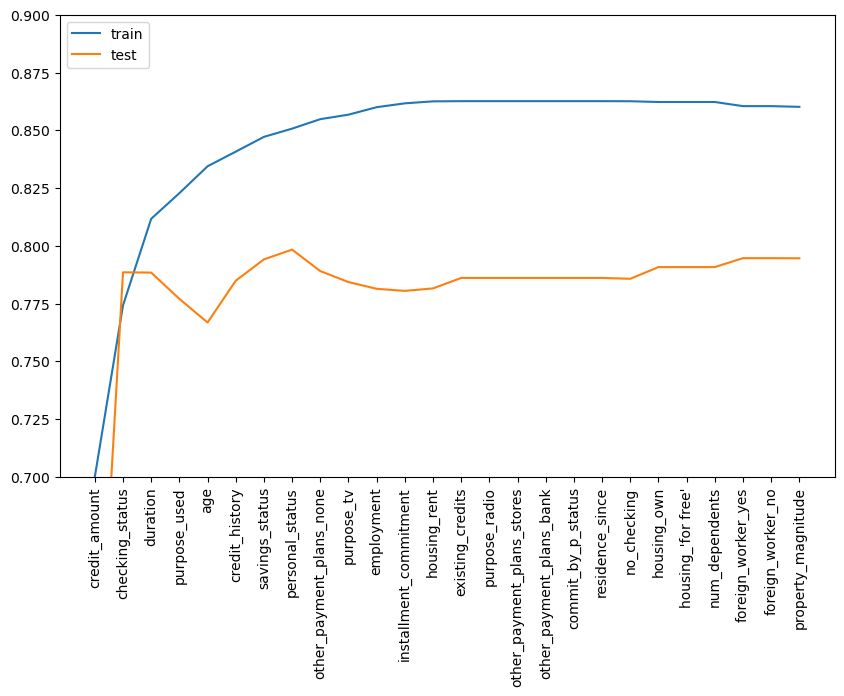

In [13]:
## Plotting AUC of train and test data by each additional feature
x = np.array(range(0,len(auc_values_train)))
plt.figure(figsize=(10, 6))
plt.xticks(x, current_variables, rotation=90)

y_train_plot = np.array(auc_values_train)
y_test_plot = np.array(auc_values_test)

plt.plot(x, y_train_plot, label='train')
plt.plot(x, y_test_plot, label='test')
plt.ylim((0.7, 0.9))

plt.legend(loc="upper left")
plt.show()

In [14]:
variables = current_variables[:8]
x_train_norm_os_model = x_train_norm_os[variables]
x_test_norm_model = x_test_norm[variables]

In [15]:
classif = AdaBoostClassifier(random_state=1)
classif.fit(x_train_norm_os_model, y_train_os)
y_prob = classif.predict_proba(x_test_norm_model)[:,1]
y_hat = classif.predict(x_test_norm_model)

print(accuracy_score(y_test, y_hat))
print(recall_score(y_test, y_hat))
print(roc_auc_score(y_test, y_prob))

0.765
0.7333333333333333
0.7983333333333333


In [16]:
np.random.seed(1)
scores_df = pd.DataFrame(index=metric_names)
results = []

# define classifier, feature selector, and cv method
classif = AdaBoostClassifier(random_state=1)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=1)

# define the pipeline to evaluate
pipeline = Pipeline(steps=[('lr', classif)])

# define grid
grid = dict()
grid['lr__n_estimators'] = [50, 70, 100, 150]
grid['lr__learning_rate'] = [0.75, 1, 1.25]

# define the grid search
search = GridSearchCV(estimator=pipeline, 
                      param_grid=[grid],
                      scoring='roc_auc',
                      n_jobs=-1, 
                      cv=cv)

search.fit(x_train_norm_os_model, y_train_os)
# print the best parameters
print(search.best_params_)
cv_results = pd.DataFrame(search.cv_results_)
y_hat = search.predict(x_test_norm_model)
y_prob = search.predict_proba(x_test_norm_model)

# loop over evaluation metrics
for n in metrics:
    if n == roc_auc_score:
        score = n(y_test, y_prob[:,1])
        results.append(score)
    else:
        score = n(y_test, y_hat)
        results.append(score)

scores_df['result'] = results
scores_df

{'lr__learning_rate': 0.75, 'lr__n_estimators': 100}


,result
accuracy,0.765000
recall,0.766667
roc_auc,0.787143


In [17]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__learning_rate,param_lr__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,mean_test_score,std_test_score,rank_test_score
0,0.087154,0.007370,0.010798,0.008208,0.75,50,"{'lr__learning_rate': 0.75, 'lr__n_estimators'...",0.799282,0.746401,0.776061,...,0.750944,0.789484,0.785644,0.789338,0.791587,0.773961,0.809961,0.780462,0.023677,4
1,0.118542,0.011690,0.016287,0.007574,0.75,70,"{'lr__learning_rate': 0.75, 'lr__n_estimators'...",0.794016,0.748889,0.776861,...,0.745137,0.793199,0.780831,0.797300,0.791342,0.777828,0.805159,0.781822,0.021782,2
2,0.174834,0.015449,0.020808,0.007231,0.75,100,"{'lr__learning_rate': 0.75, 'lr__n_estimators'...",0.791995,0.754237,0.775302,...,0.752278,0.796240,0.779803,0.798120,0.791076,0.779432,0.806390,0.781995,0.021190,1
3,0.257421,0.018619,0.027185,0.008666,0.75,150,"{'lr__learning_rate': 0.75, 'lr__n_estimators'...",0.784137,0.748663,0.767955,...,0.749200,0.798812,0.777190,0.801445,0.789852,0.782044,0.811787,0.781311,0.020742,3
4,0.085738,0.010422,0.010428,0.008613,1,50,"{'lr__learning_rate': 1, 'lr__n_estimators': 50}",0.799077,0.762814,0.758393,...,0.753386,0.784504,0.766557,0.792108,0.773544,0.778486,0.795925,0.777702,0.019792,9
5,0.119638,0.009125,0.013449,0.008329,1,70,"{'lr__learning_rate': 1, 'lr__n_estimators': 70}",0.794954,0.753743,0.757962,...,0.759029,0.794016,0.769416,0.801547,0.792811,0.782044,0.804297,0.779129,0.018610,6
6,0.167267,0.014370,0.019996,0.006792,1,100,"{'lr__learning_rate': 1, 'lr__n_estimators': 100}",0.787341,0.747182,0.759768,...,0.751683,0.798608,0.770033,0.803846,0.794893,0.779720,0.802327,0.777753,0.020403,8
7,0.252676,0.021505,0.030240,0.009722,1,150,"{'lr__learning_rate': 1, 'lr__n_estimators': 150}",0.787688,0.744755,0.759563,...,0.751252,0.801670,0.767153,0.804605,0.792056,0.784307,0.809879,0.779893,0.021098,5
8,0.085451,0.007632,0.009417,0.007815,1.25,50,"{'lr__learning_rate': 1.25, 'lr__n_estimators'...",0.805895,0.751049,0.767401,...,0.746655,0.780096,0.769087,0.783510,0.791525,0.776779,0.794221,0.774793,0.021793,12
9,0.119444,0.014531,0.015168,0.002821,1.25,70,"{'lr__learning_rate': 1.25, 'lr__n_estimators'...",0.800731,0.755389,0.761922,...,0.751252,0.773523,0.776018,0.790097,0.798241,0.777314,0.811664,0.778120,0.022129,7


In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc

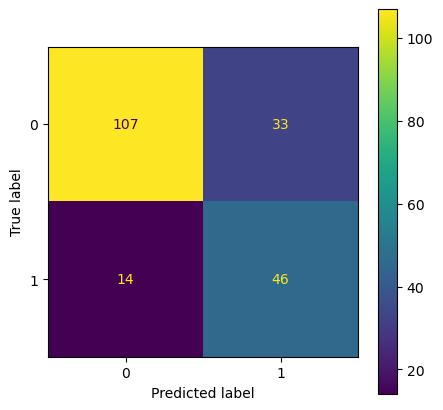

In [19]:
# confusion matrix
plt.rcParams['figure.figsize']=(5, 5) 
cm = confusion_matrix(y_test, y_hat)  
cm_display = ConfusionMatrixDisplay(cm, display_labels=search.classes_)

cm_display.plot()
plt.show() 

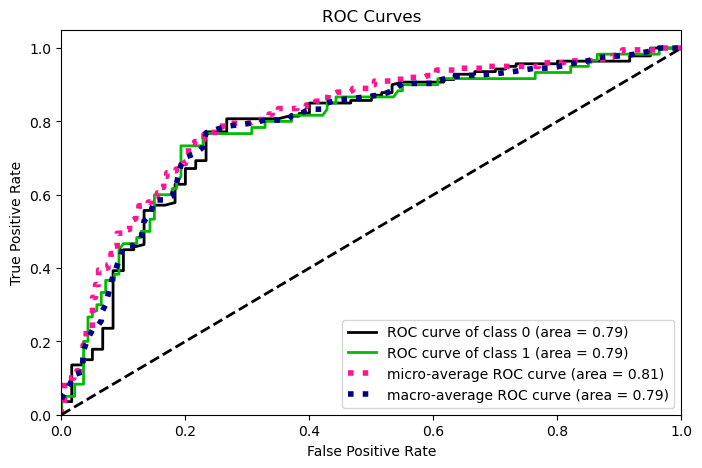

In [20]:
# roc curve
plt.rcParams['figure.figsize']=(8, 5) 
plot_roc(y_test, y_prob)
plt.show()